# Risk forecasting DNN model

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split

In [3]:
SERIES_PERIOD = 'max'
SERIES_INTERVAL = '1d'

LOOKBACK_WINDOW = 10
PREDICTION_LEN = 1
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.9

EPOCHS = 10
BATCH_SIZE = 32

AL_ITERATIONS = 10

### Dataset

In [4]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# gather other variables
_open = sp500_history.Open[:-1]
_high = sp500_history.High[:-1]
_low = sp500_history.Low[:-1]
_volume = sp500_history.Volume[:-1]

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'close': (close - close.min()) / close.max(),
    'returns': log_returns / log_returns.max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X = X[list(X)].astype(np.float64)
X

,open,high,low,volume,close,returns,volatility
Date,,,,,,,
1950-01-10,0.003545,0.000077,0.000077,0.000129,0.000077,-0.026755,0.041578
1950-01-11,0.003557,0.000089,0.000090,0.000170,0.000090,0.032097,0.026233
1950-01-12,0.003488,0.000021,0.000021,0.000200,0.000021,-0.177951,0.085538
1950-01-13,0.003470,0.000002,0.000002,0.000231,0.000002,-0.049140,0.082654
1950-01-16,0.003480,0.000012,0.000013,0.000068,0.000013,0.027332,0.077147
...,...,...,...,...,...,...,...
2022-06-07,0.852630,0.860869,0.850104,0.303397,0.863957,0.086503,0.116048
2022-06-08,0.863172,0.859889,0.855754,0.269679,0.854594,-0.099046,0.121327
2022-06-09,0.853708,0.851372,0.836920,0.278595,0.834173,-0.219823,0.116419


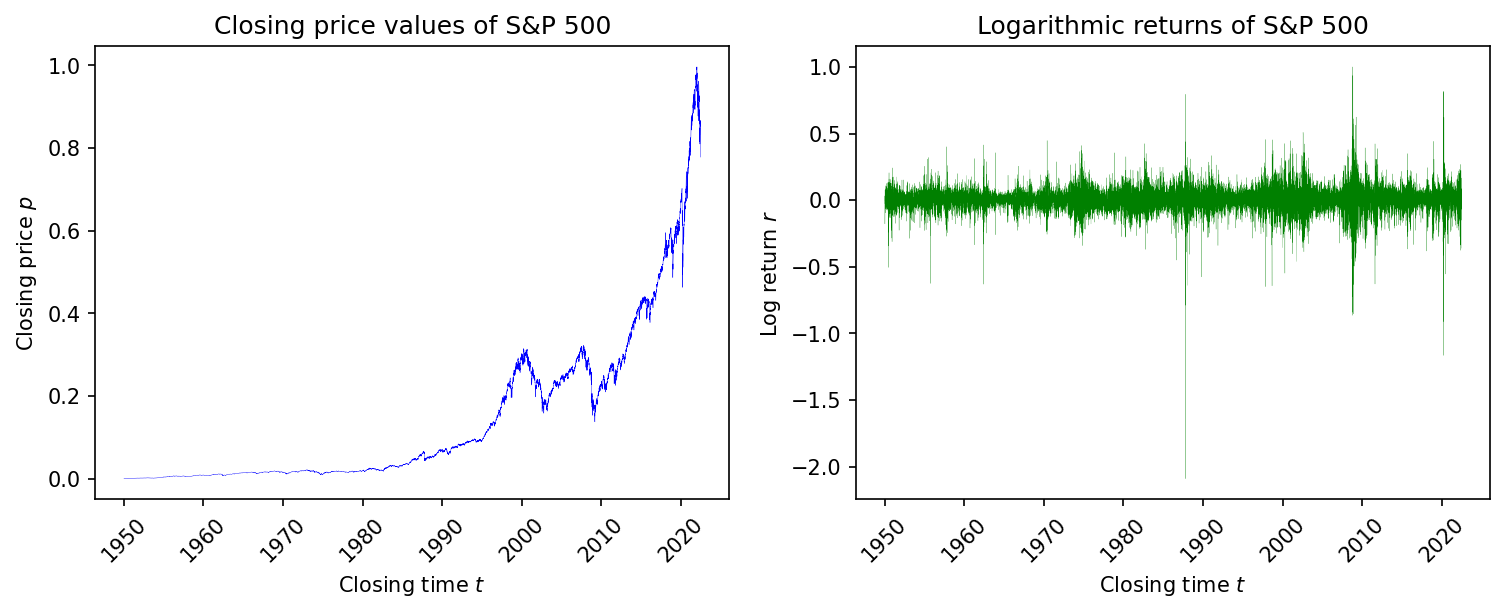

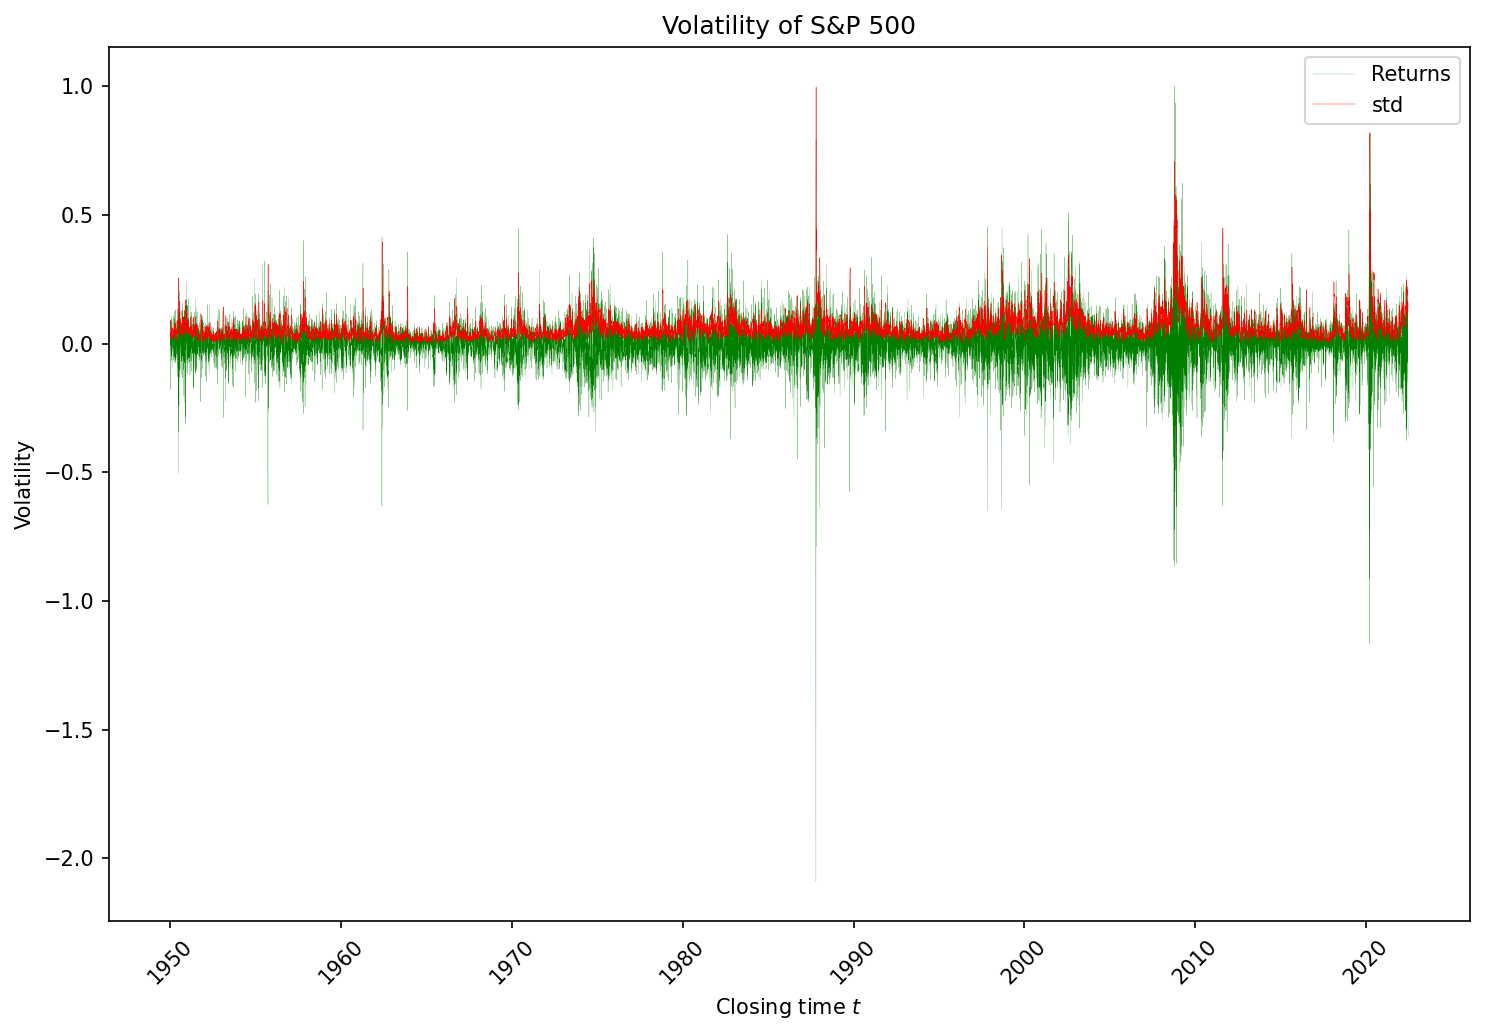

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.1, color='g', label='Returns')
ax.plot(X.volatility, linewidth=0.2, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW - PREDICTION_LEN):
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + PREDICTION_LEN])

# convert X, y to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)
X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

# X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=(1 - TRAIN_VAL_SPLIT), shuffle=True)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

90% training data, 10% testing data
(16392, 10, 7) (16392, 1) 
 (1822, 10, 7) (1822, 1)


In [7]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

models = {
    'LSTM': lstm_model
}

for model in models.values():
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [8]:
# histories = {}
# for m in range(len(models)):
#     model = list(models.values())[m]
#     history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))
#     histories.update({list(models.keys())[m]: history.history})

In [9]:
def initial_selection(X, y, k=BATCH_SIZE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(X, axis=0)

    # compute euclidean distance
    distances = np.max(np.linalg.norm(X - centroid, axis=2), axis=1)

    # select instances with smallest distance
    train_indices = np.argpartition(distances, k)[:k]
    X_instances = X[train_indices]
    y_instances = y[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(X.shape[0]), train_indices)
    X_instances_val = X[val_indices]
    y_instances_val = y[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


def select_instances(model, X_t, y_t, X_v, y_v, k=BATCH_SIZE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.squeeze(1)
    _y_t = y_t.squeeze(1)
    distances = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distances, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v

In [10]:
# initial training over seed dataset
X_pool, y_pool, X_val, y_val = initial_selection(X_train, y_train, k=200)

history = lstm_model.fit(X_pool, y_pool, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)
histories = {
    'loss': history.history['loss'],
    'mse': history.history['mse'],
    'val_loss': history.history['val_loss'],
    'val_mse': history.history['val_mse']
}

for it in range(50):
    print(f"Iteration {it}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
    if X_val.shape[0] >= BATCH_SIZE:
        X_pool, y_pool, X_val, y_val = select_instances(lstm_model, X_pool, y_pool, X_val, y_val, k=100)
        history = lstm_model.fit(X_pool, y_pool, epochs=1, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
        
        histories['loss'].append(history.history['loss'][0])
        histories['mse'].append(history.history['mse'][0])
        histories['val_loss'].append(history.history['val_loss'][0])
        histories['val_mse'].append(history.history['val_mse'][0])
    else:
        break

Iteration 0; pool = 200, val = 16192
1/1 [==============================] - 0s 75ms/step - loss: 0.0108 - mse: 2.5617e-04 - val_loss: 0.0241 - val_mse: 0.0012
Iteration 1; pool = 300, val = 16092
2/2 [==============================] - 0s 79ms/step - loss: 0.0093 - mse: 1.9207e-04 - val_loss: 0.0280 - val_mse: 0.0027
Iteration 2; pool = 400, val = 15992
2/2 [==============================] - 0s 107ms/step - loss: 0.0100 - mse: 2.0527e-04 - val_loss: 0.0303 - val_mse: 0.0029
Iteration 3; pool = 500, val = 15892
2/2 [==============================] - 0s 93ms/step - loss: 0.0116 - mse: 2.4837e-04 - val_loss: 0.0315 - val_mse: 0.0027
Iteration 4; pool = 600, val = 15792
3/3 [==============================] - 0s 60ms/step - loss: 0.0088 - mse: 1.6652e-04 - val_loss: 0.0327 - val_mse: 0.0027
Iteration 5; pool = 700, val = 15692
3/3 [==============================] - 0s 56ms/step - loss: 0.0092 - mse: 1.5666e-04 - val_loss: 0.0342 - val_mse: 0.0028
Iteration 6; pool = 800, val = 15592
3/3 [===

In [11]:
predictions = {}
metrics = {}
for m in range(len(models.values())):
    model = list(models.values())[m]
    prediction = model.predict(X_test)
    
    mae = np.abs(np.subtract(y_test, prediction)).mean()
    mse = np.square(np.subtract(y_test, prediction)).mean()
    mape = np.abs((y_test - prediction) / y_test).mean() * 100

    _msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(prediction + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    metrics.update({
        list(models.keys())[m]: {
            'mae': mae,
            'mse': mse,
            'msle': msle,
            'mape': mape
        }
    })

    predictions.update({    
        list(models.keys())[m]: prediction * volatility.max() + volatility.min()
    })

    print(f" - {list(models.keys())[m]}: \n\t mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")


x = 2
y = max(len(metrics) // x, 1)

 - LSTM: 
	 mae = 0.01821; mse = 0.00071; msle = 0.00054; mape = 29.89146%


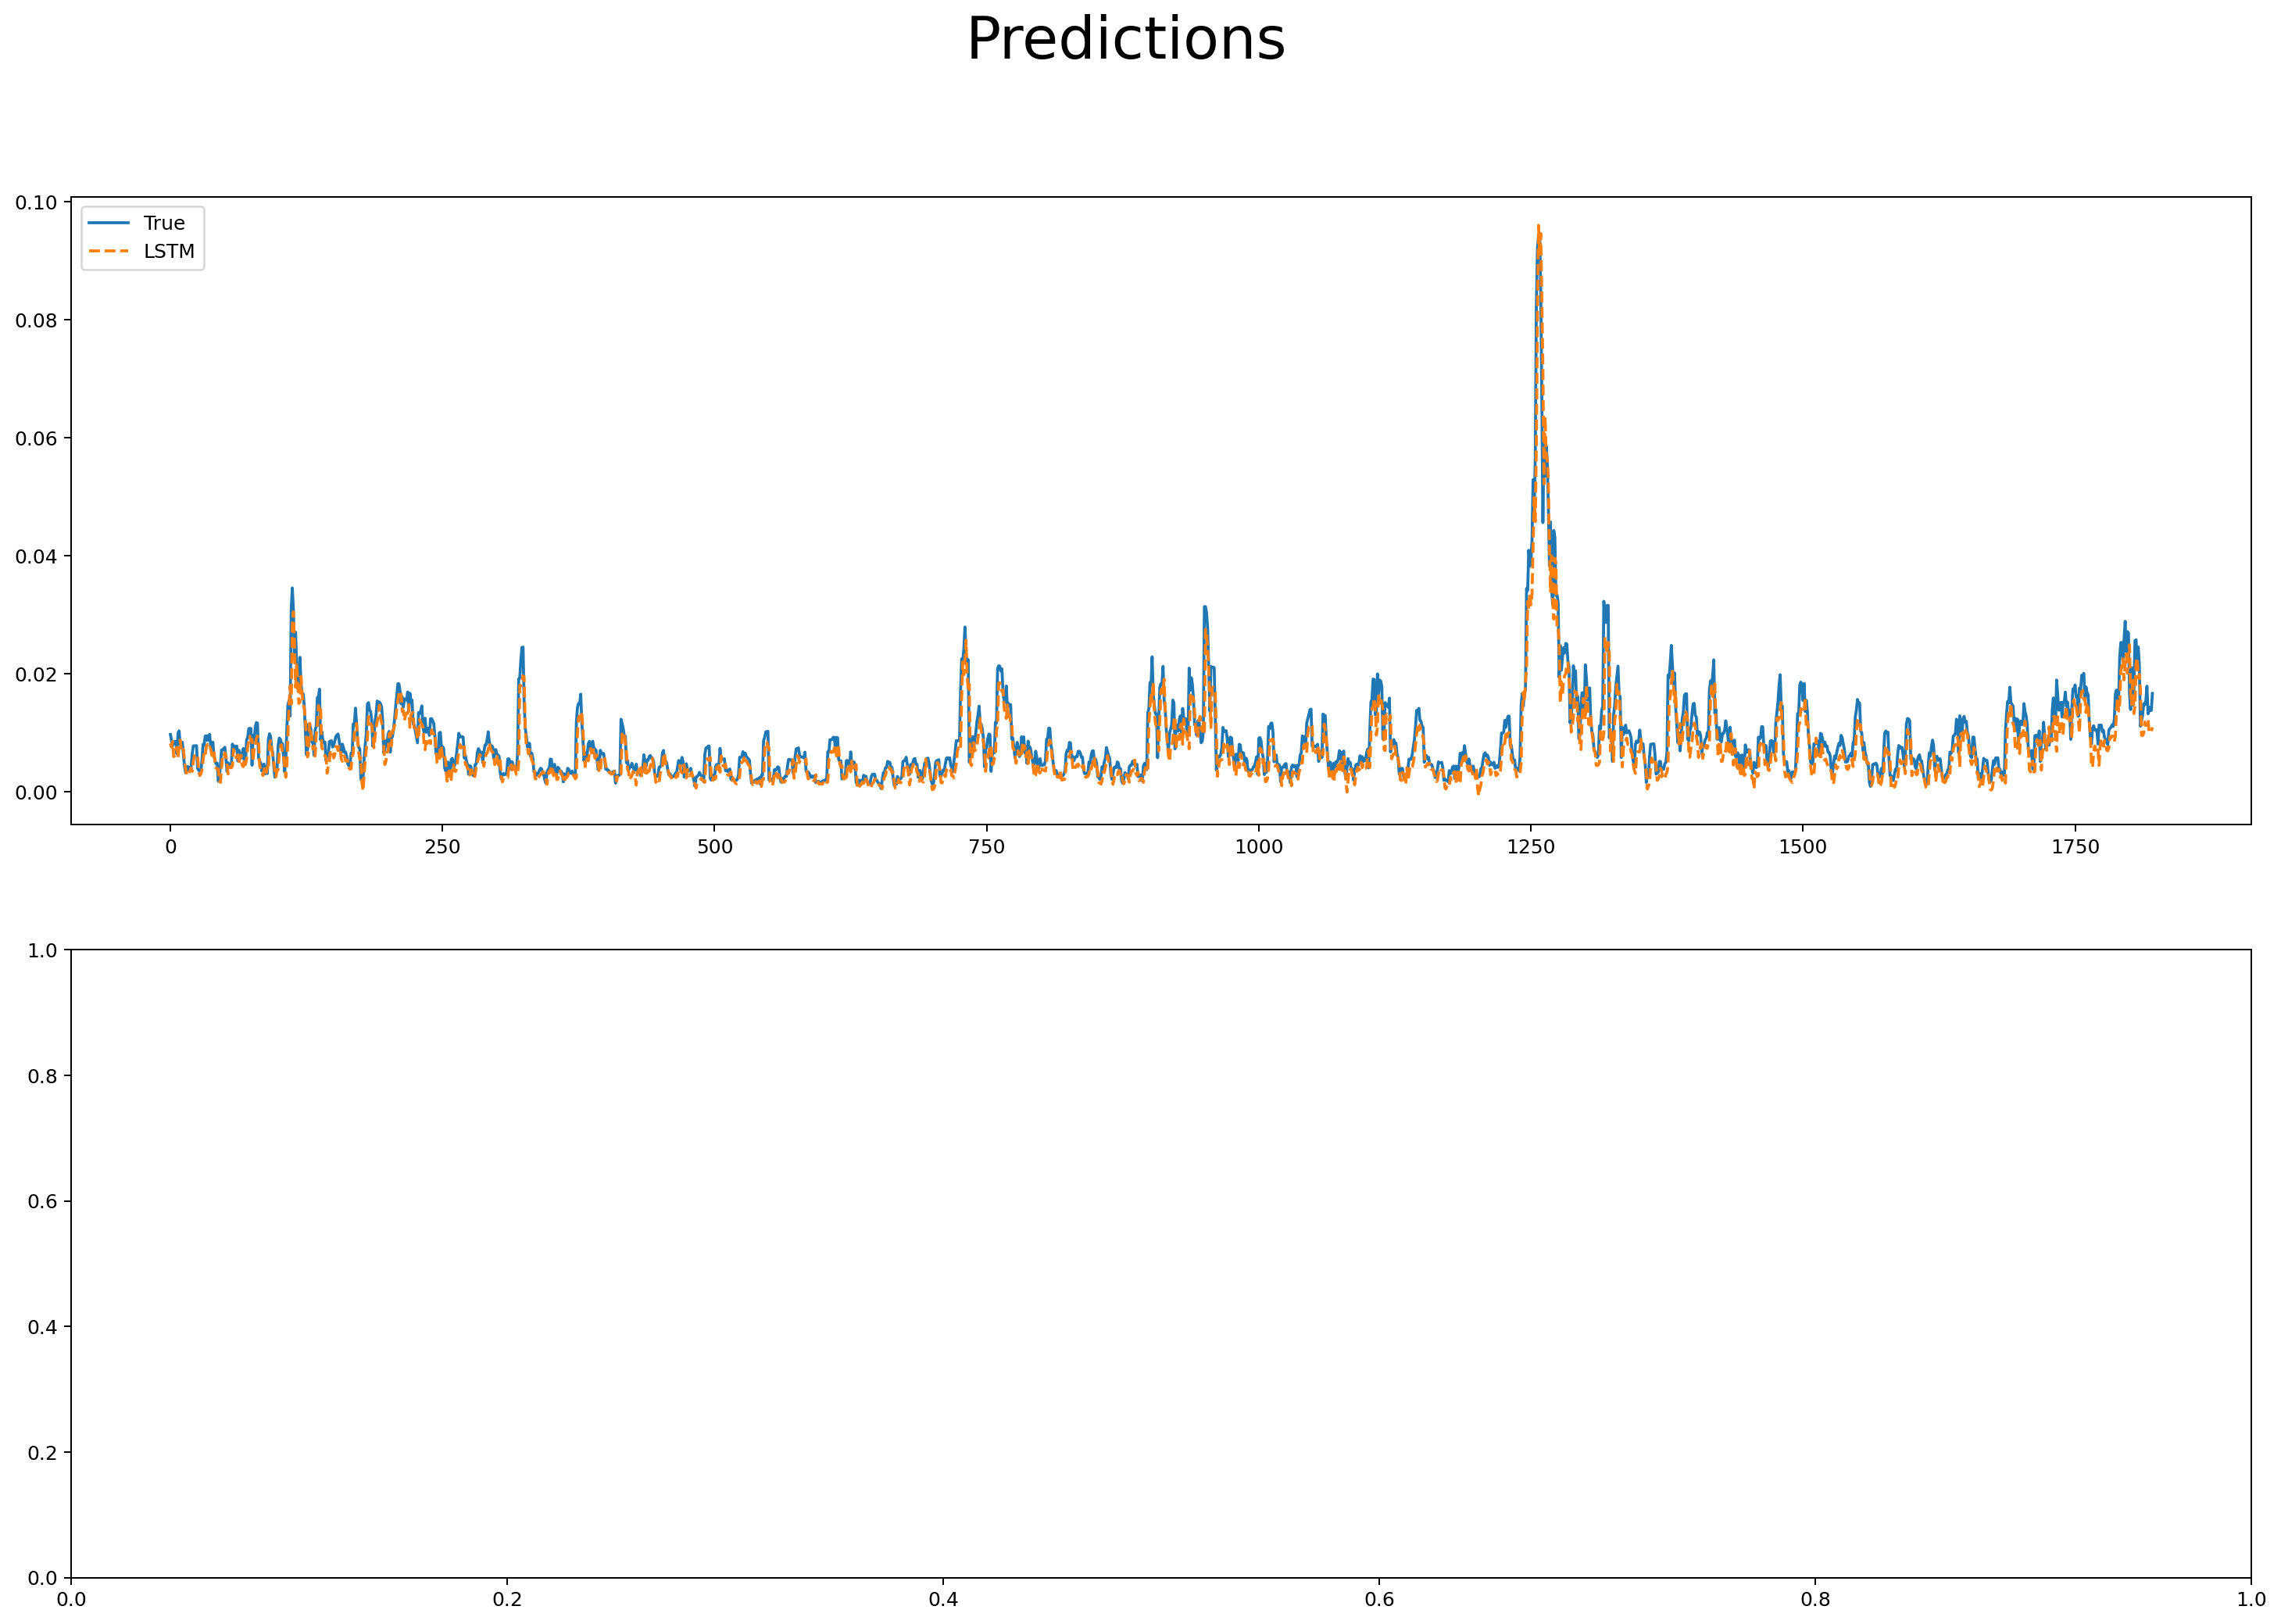

In [12]:
y_test_unscaled = y_test * volatility.max() + volatility.min()

fig, ax = plt.subplots(x, y, figsize=(10 * x, 13*y), dpi=180)
fig.suptitle("Predictions", fontsize=30)

ind = 0
if y > 1 and x > 1:
    for _y in range(y):
        for _x in range(x):
            if (_y * x + _x) < len(metrics):
                ax[_x, _y].plot(y_test_unscaled, label='True')
                ax[_x, _y].plot(predictions[list(metrics.keys())[ind]], linestyle='--', label=list(metrics.keys())[ind])
                ax[_x, _y].legend(loc=2)
                ind += 1
else:
    for _x in range(x):
        if _x < len(metrics):
            ax[_x].plot(y_test_unscaled, label='True')
            ax[_x].plot(predictions[list(metrics.keys())[_x]], linestyle='--', label=list(metrics.keys())[_x])
            ax[_x].legend(loc=2)

plt.show()

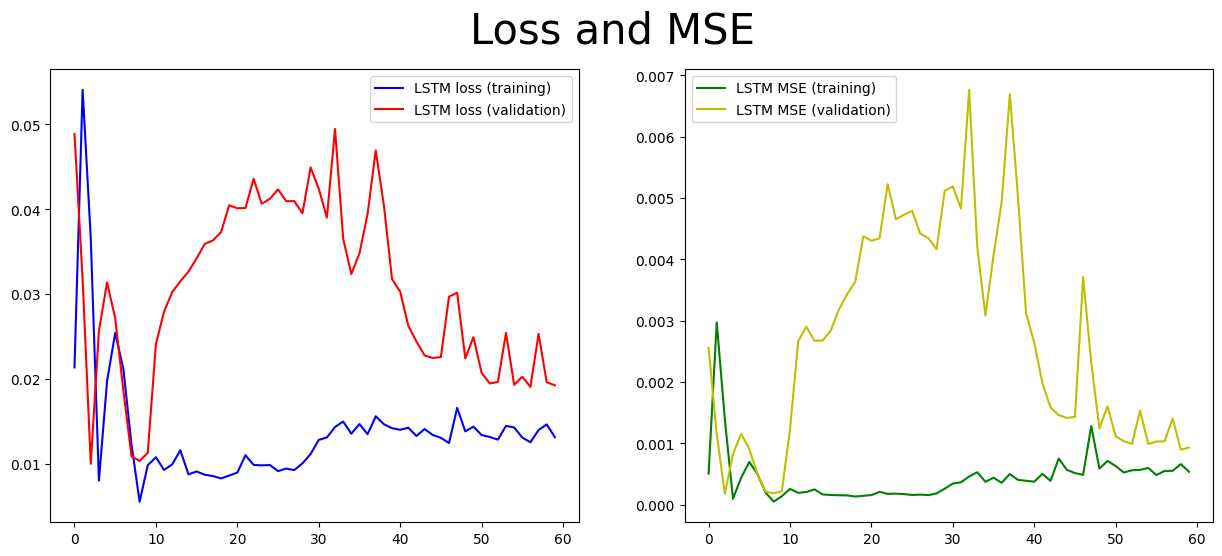

In [13]:
fig, ax = plt.subplots(len(metrics), 2, figsize=(15, 6 * len(metrics)), dpi=100)
fig.suptitle("Loss and MSE", fontsize=30)

ax[0].plot(histories['loss'], color='b', label="LSTM loss (training)")
ax[0].plot(histories['val_loss'], color='r', label="LSTM loss (validation)")
ax[0].legend(loc=0)

ax[1].plot(histories['mse'], color='g', label="LSTM MSE (training)")
ax[1].plot(histories['val_mse'], color='y', label="LSTM MSE (validation)")
ax[1].legend(loc=0)

# for m in range(len(metrics.keys())):
#     model = list(models.keys())[m]

#     ax[m, 0].plot(histories[model]['loss'], color='b', label=f"{model} loss (training)")
#     ax[m, 0].plot(histories[model]['val_loss'], color='g', label=f"{model} loss (validation)")
#     ax[m, 0].legend(loc=0)

#     ax[m, 1].plot(histories[model]['mse'], color='r', label=f"{model} MSE (training)")
#     ax[m, 1].plot(histories[model]['val_mse'], color='y', label=f"{model} MSE (validation)")
#     ax[m, 1].legend(loc=0)